# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data and settings

In [2]:
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names


datasets = ['adult', 'moons', 'circles','seer', 'cutract', 'breast_cancer'] 
model_name = 'ctgan'  # synthetic data model
    
nsyn = 4000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None
p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 10  # number of models in ensemble

load = True  # results
load_syn = True # data
save = True  # save results and data
max_n = 1000

verbose = False

for dataset in datasets:
    print('Dataset:', dataset)
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)


    nsyn = len(X_syns[0])
    workspace_folder, results_folder = get_folder_names(dataset=dataset, model_name=model_name, nsyn=nsyn, max_n=max_n)
    print('Shape of each synthetic dataset:', X_syns[0].shape)
    print('Target type:', X_gt.targettype)




Dataset: adult
n_total 32561 n_train: 1000
Shape of each synthetic dataset: (4000, 14)
Target type: classification
Dataset: moons
n_total 10000 n_train: 1000
Shape of each synthetic dataset: (4000, 3)
Target type: classification
Dataset: circles
n_total 10000 n_train: 1000
Shape of each synthetic dataset: (4000, 3)
Target type: classification
Dataset: seer
n_total 20000 n_train: 1000
Shape of each synthetic dataset: (4000, 7)
Target type: classification
Dataset: cutract


KeyboardInterrupt: 

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')


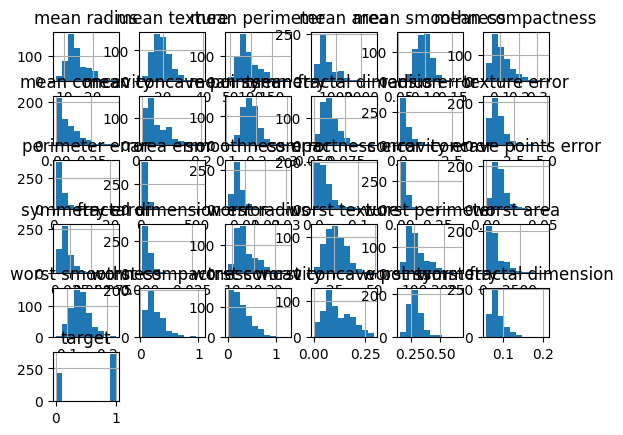

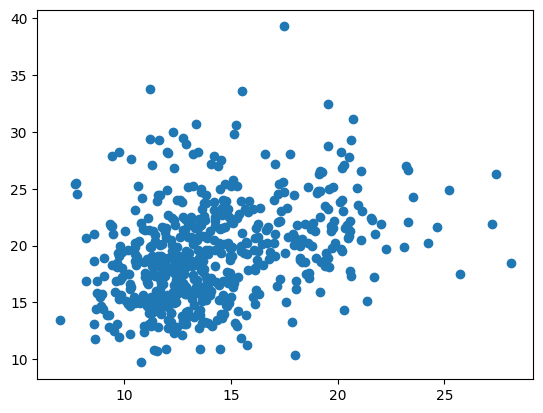

In [ ]:
from DGE_data import load_real_data

X = load_real_data(dataset=dataset, max_n=max_n).dataframe()

X.hist()
print(X.columns)
plt.show()
X = X.to_numpy()
plt.scatter(X[:,0], X[:,1])
plt.show()

Dataset: cutract
n_total 20000 n_train: 1000
Shape of each synthetic dataset: (4000, 7)
Target type: classification


In [7]:
from synthcity.utils import reproducibility


for dataset in datasets:
    print('Dataset:', dataset)
    nsyn=5000
    max_n=2000
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                    p_train=p_train,
                                    n_models=n_models,
                                    model_name=model_name,
                                    load_syn=load_syn,
                                    verbose=verbose,
                                    max_n=max_n,
                                    nsyn=nsyn)


    nsyn = len(X_syns[0])
    workspace_folder, results_folder = get_folder_names(dataset=dataset, model_name=model_name, nsyn=nsyn, max_n=max_n)
    print('Shape of each synthetic dataset:', X_syns[0].shape)
    print('Target type:', X_gt.targettype)
    models = []
    model_real = None

    reproducibility.enable_reproducible_results(seed=2023)


    from DGE_utils import tt_predict_performance
    
    X_test_r = X_gt.test()
    X_test_r.targettype = X_gt.targettype
    X_train_r = X_gt.train()
    X_train_r.targettype = X_gt.targettype
    for quantile in [0.8, 0.9]:
        scores_TSTS = [0]*len(X_syns)
        scores_TSTR = [0]*len(X_syns)
        scores_TSTR_minority = [0]*len(X_syns)
        scores_TSTS_minority = [0]*len(X_syns)
        if True:#dataset in ['moons', 'circles']:
            center = X_test_r.unpack(as_numpy=True)[0].mean(axis=0)
            print(center)
            dis_to_center = lambda x: np.sum((x.unpack(as_numpy=True)[0]-center)**2,axis=1)
            threshold = np.quantile(dis_to_center(X_test_r), quantile)
            minority = lambda x: x[dis_to_center(x)>threshold]
        elif dataset in ['seer', 'cutract']:
            threshold = X_test_r.data.age.quantile(0.8)
            minority = lambda x: x[x.data.age>threshold]
        elif dataset=='adult':
            threshold = X_test_r.data['native.country'].mean()
            minority = lambda x: x[x.data['native.country']< threshold]
        elif dataset=='breast_cancer':
            threshold = X_test_r.data['mean radius'].quantile(0.2)
            minority = lambda x: x[x.data['mean radius']<threshold]


        X_test_r_minority = minority(X_test_r)
        X_test_r_minority = GenericDataLoader(X_test_r_minority, target_column='target')
        X_test_r_minority.targettype = X_gt.targettype

        scores_TRTR, model_real = tt_predict_performance(X_test_r, X_train_r, model=model_real)
        scores_TRTR_minority, _ = tt_predict_performance(X_test_r_minority, X_train_r, model=model_real)


        for i, X_syn in enumerate(X_syns):
            X_test, X_train = X_syn.test(), X_syn.train()
            X_test.targettype = X_train.targettype = X_gt.targettype
            X_test_s_minority = minority(X_test)
            X_test_s_minority = GenericDataLoader(X_test_s_minority, target_column='target')
            X_test_s_minority.targettype = X_gt.targettype
            if len(models)==len(X_syns):
                model = models[i]
            else:
                model = None
            scores_TSTS[i], model = tt_predict_performance(X_test, X_train, model=model)
            models.append(model)

            scores_TSTS_minority[i], _ = tt_predict_performance(X_test_s_minority, X_train, model=model)
            scores_TSTR[i], _ = tt_predict_performance(X_test_r, X_train, model=model)
            scores_TSTR_minority[i], _ = tt_predict_performance(X_test_r_minority, X_train, model=model)
            

        scores_TSTR_minority = pd.concat(scores_TSTR_minority, axis=0)
        scores_TSTR = pd.concat(scores_TSTR, axis=0)
        scores_TSTS = pd.concat(scores_TSTS, axis=0)
        scores_TSTS_minority = pd.concat(scores_TSTS_minority, axis=0)

        
        for metric in ['Acc', 'AUC']:

            df = pd.concat([scores_TRTR[metric], scores_TSTR[metric], scores_TSTS[metric], scores_TRTR_minority[metric], scores_TSTR_minority[metric], scores_TSTS_minority[metric]],axis=1)
            df.columns = ['TRTR','TSTR', 'TSTS', 
                            'TRTR (M)','TSTR (M)','TSTS (M)']
            import matplotlib.pyplot as plt
            import seaborn as sns

            plt.figure(4,4, tight_layout=True)
            sns.boxplot(df)
            name = f'Dataset: {dataset} metric: {metric}, quantile: {quantile}'
            filename_plot = f'{dataset}_{quantile}_{metric}.png'
            plt.title(name)
            plt.savefig(f'temp/{filename_plot}')
            plt.show()



Dataset: adult
n_total 32561 n_train: 2000
Shape of each synthetic dataset: (5000, 14)
Target type: classification
[3.85772390e+01 3.87235365e+00 1.89829449e+05 1.00819018e+01
 2.61100749e+00 6.56912405e+00 1.44635320e+00 3.66509604e+00
 6.69022611e-01 1.07941007e+03 8.66509277e+01 4.04342463e+01
 3.66923857e+01]


<AxesSubplot: >

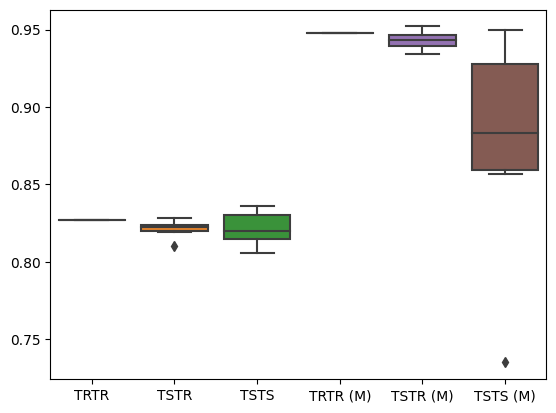

In [28]:
metric= 'Acc'
df = pd.concat([scores_TRTR[metric], scores_TSTR[metric], scores_TSTS[metric], scores_TRTR_minority[metric], scores_TSTR_minority[metric], scores_TSTS_minority[metric]],axis=1)
df.columns = ['TRTR','TSTR', 'TSTS', 
                'TRTR (M)','TSTR (M)','TSTS (M)']
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(df)
sns.title('Dataset: '+dataset)
plt.show()


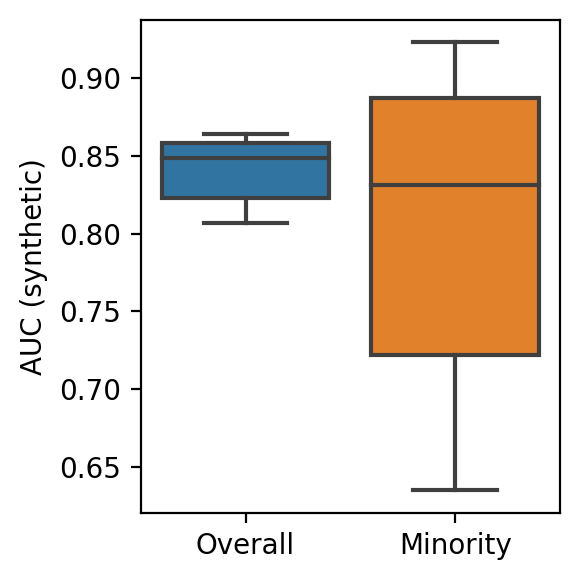

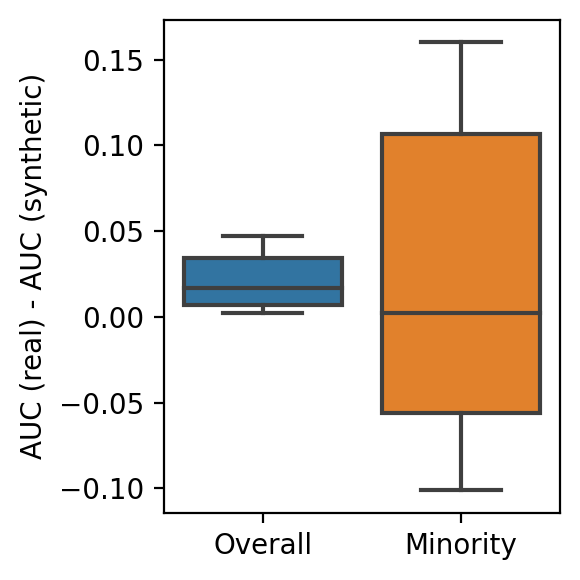

In [42]:
metric= 'AUC'
plotting = sns.boxplot
#plotting = lambda x: seaborn.violinplot(x, cut=0)
df2 = df[['TSTS', 'TSTS (M)']]
df2.columns = ['Overall', 'Minority']
plt.figure(figsize=(3,3), dpi=200, tight_layout=True)
plotting(df2)
plt.ylabel('AUC (synthetic)')
plt.savefig(results_folder+'_AUC_synthetic.png')
plt.show()
plt.figure(figsize=(3,3), dpi=200, tight_layout=True)
X = df[['TSTR','TSTR (M)']].to_numpy()-df[['TSTS', 'TSTS (M)']].to_numpy()

X = pd.DataFrame(X, columns= ['Overall', 'Minority'])
plt.ylabel('AUC (real) - AUC (synthetic)')
plotting(X)
plt.savefig(results_folder+'_AUC_real_minus_synthetic.png')

(50, 2)

In [76]:
print('TSTR', scores_TSTR.mean(axis=0))
print('TSTR (minority)', scores_TSTR_minority.mean(axis=0))

print('TRTR', scores_TRTR.mean(axis=0))
print('TRTR (minority)', scores_TRTR_minority.mean(axis=0))

print('TSTS', scores_TSTS.mean(axis=0))
print('TSTS (minority)', scores_TSTS_minority.mean(axis=0))

TSTR AUC          0.89722
Acc          0.81400
F1           0.80508
Precision    0.84646
Recall       0.77014
NLL          0.41190
Brier        0.12958
dtype: float64
TSTR (minority) AUC          0.80872
Acc          0.80264
F1           0.88164
Precision    0.84318
Recall       0.92762
NLL          0.41078
Brier        0.13084
dtype: float64
TRTR AUC          0.907
Acc          0.827
F1           0.820
Precision    0.855
Recall       0.788
NLL          0.389
Brier        0.121
dtype: float64
TRTR (minority) AUC          0.817
Acc          0.816
F1           0.893
Precision    0.832
Recall       0.964
NLL          0.400
Brier        0.128
dtype: float64
TSTS AUC          0.89066
Acc          0.81590
F1           0.79478
Precision    0.81680
Recall       0.77598
NLL          0.41560
Brier        0.13104
dtype: float64
TSTS (minority) AUC          0.84328
Acc          0.79610
F1           0.87000
Precision    0.83336
Recall       0.91544
NLL          0.39800
Brier        0.12804
dtype: f

In [ ]:
X_gt.data.target.mean()
X_gt.data.target.std()

77.09300453299109

In [ ]:
X_gt.data['age']

0      0.038076
1     -0.001882
2      0.085299
3     -0.089063
4      0.005383
         ...   
437    0.041708
438   -0.005515
439    0.041708
440   -0.045472
441   -0.045472
Name: age, Length: 442, dtype: float64

# Analyses

## Model Training

n_total 10000 n_train: 1000
Dataset moons



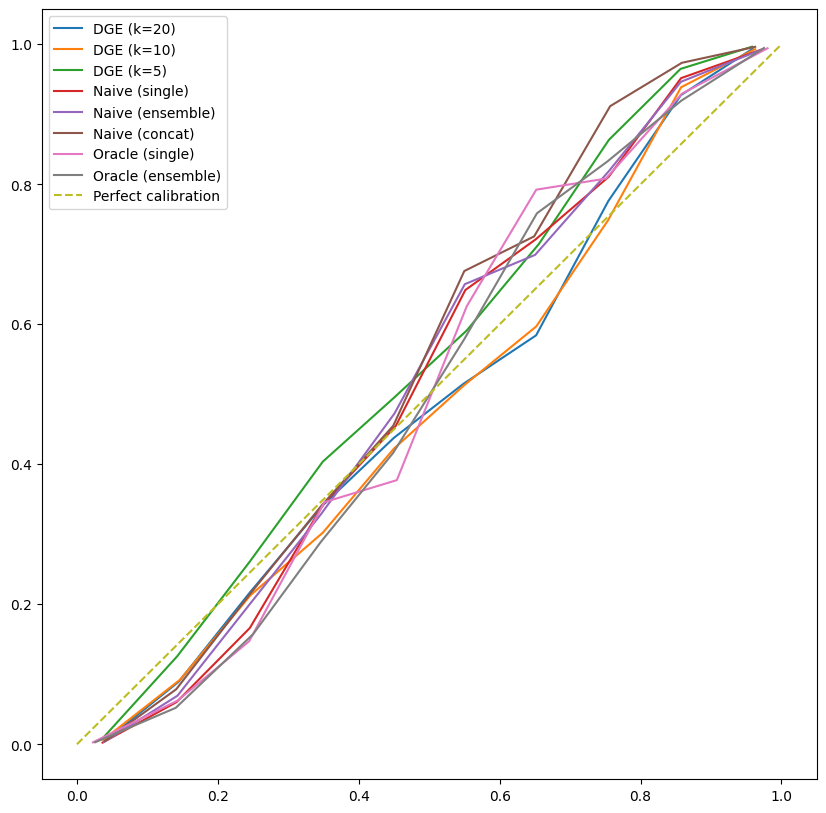

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)        &  0.975 &  0.909 &  0.909 &      0.908 &   0.910 &  0.220 &  0.064 \\
DGE (k=10)        &  0.978 &  0.916 &  0.916 &      0.915 &   0.918 &  0.207 &  0.060 \\
DGE (k=5)         &  0.983 &  0.925 &  0.924 &      0.941 &   0.907 &  0.193 &  0.055 \\
Naive (single)    &  0.989 &  0.948 &  0.948 &      0.950 &   0.946 &  0.151 &  0.041 \\
Naive (ensemble)  &  0.986 &  0.938 &  0.938 &      0.942 &   0.935 &  0.170 &  0.047 \\
Naive (concat)    &  0.989 &  0.946 &  0.945 &      0.956 &   0.935 &  0.166 &  0.044 \\
Oracle (single)   &  0.994 &  0.965 &  0.965 &      0.965 &   0.965 &  0.107 &  0.028 \\
Oracle (ensemble) &  0.993 &  0.959 &  0.959 &      0.959 &   0.960 &  0.122 &  0.032 \\
\bottomrule
\end{tabular}

n_total 10000 n_train: 1000
Dataset circles



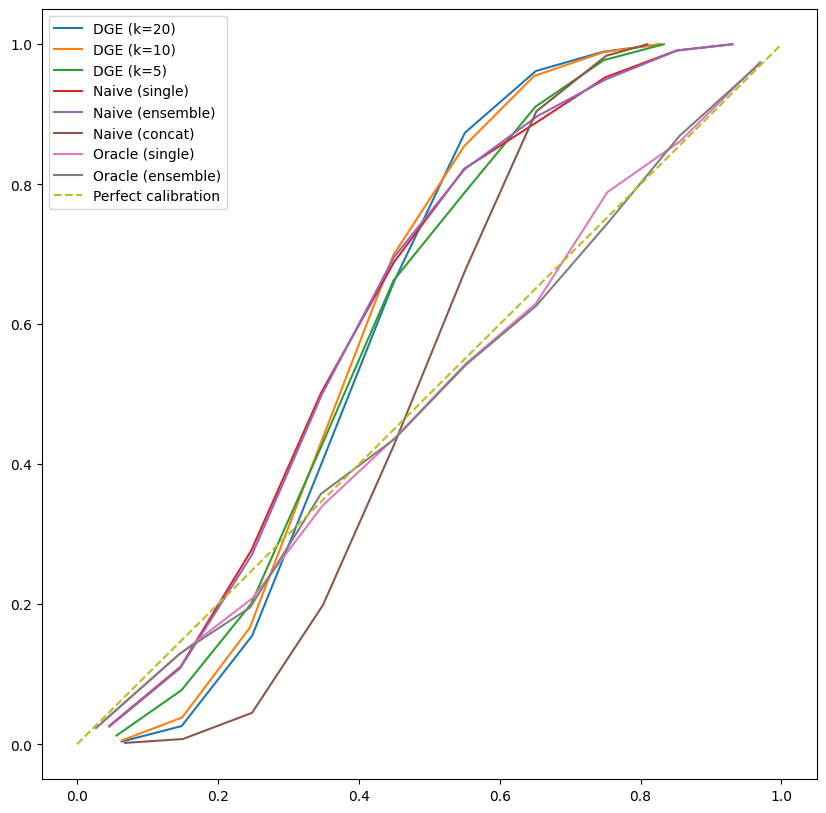

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)        &  0.954 &  0.849 &  0.830 &      0.949 &   0.737 &  0.407 &  0.125 \\
DGE (k=10)        &  0.947 &  0.829 &  0.805 &      0.937 &   0.706 &  0.421 &  0.132 \\
DGE (k=5)         &  0.933 &  0.826 &  0.806 &      0.911 &   0.722 &  0.417 &  0.131 \\
Naive (single)    &  0.947 &  0.848 &  0.832 &      0.933 &   0.751 &  0.362 &  0.112 \\
Naive (ensemble)  &  0.948 &  0.850 &  0.834 &      0.933 &   0.754 &  0.360 &  0.111 \\
Naive (concat)    &  0.955 &  0.880 &  0.878 &      0.893 &   0.864 &  0.400 &  0.118 \\
Oracle (single)   &  0.958 &  0.889 &  0.890 &      0.885 &   0.895 &  0.263 &  0.080 \\
Oracle (ensemble) &  0.958 &  0.889 &  0.890 &      0.883 &   0.897 &  0.262 &  0.080 \\
\bottomrule
\end{tabular}

n_total 20640 n_train: 2064
n_total 20000 n_train: 2000
Dataset seer



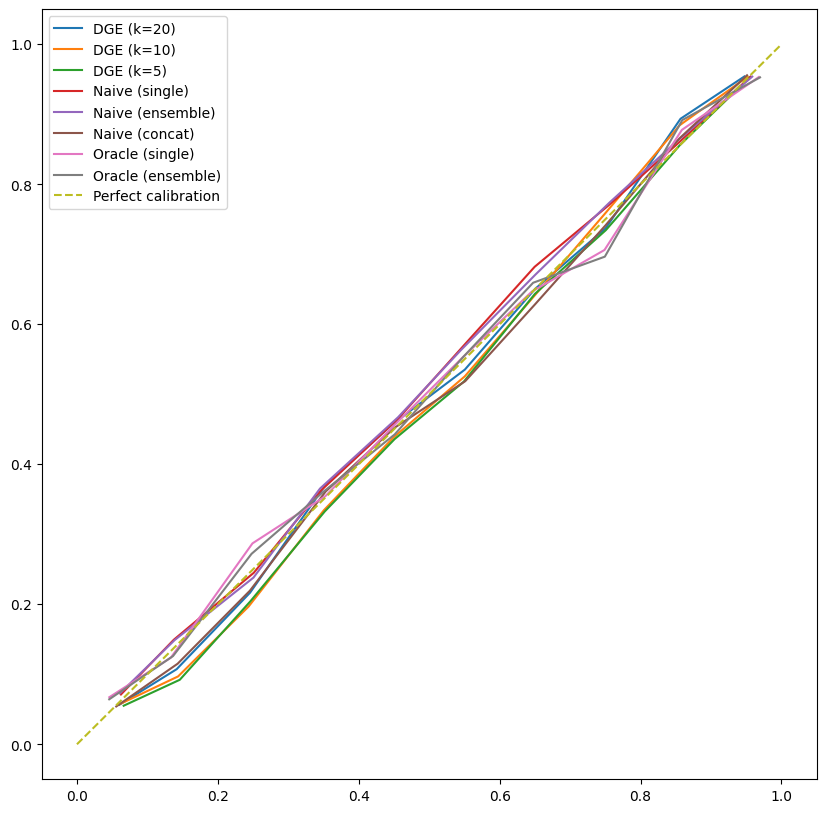

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)        &  0.907 &  0.829 &  0.828 &      0.833 &   0.824 &  0.386 &  0.120 \\
DGE (k=10)        &  0.907 &  0.830 &  0.830 &      0.828 &   0.832 &  0.387 &  0.120 \\
DGE (k=5)         &  0.907 &  0.829 &  0.829 &      0.827 &   0.832 &  0.387 &  0.120 \\
Naive (single)    &  0.906 &  0.830 &  0.828 &      0.841 &   0.815 &  0.391 &  0.120 \\
Naive (ensemble)  &  0.906 &  0.829 &  0.825 &      0.845 &   0.806 &  0.391 &  0.120 \\
Naive (concat)    &  0.910 &  0.830 &  0.831 &      0.826 &   0.835 &  0.380 &  0.119 \\
Oracle (single)   &  0.911 &  0.833 &  0.830 &      0.845 &   0.816 &  0.379 &  0.117 \\
Oracle (ensemble) &  0.911 &  0.834 &  0.831 &      0.844 &   0.819 &  0.378 &  0.117 \\
\bottomrule
\end{tabular}

n_total 20000 n_train: 2000
Dataset cutract



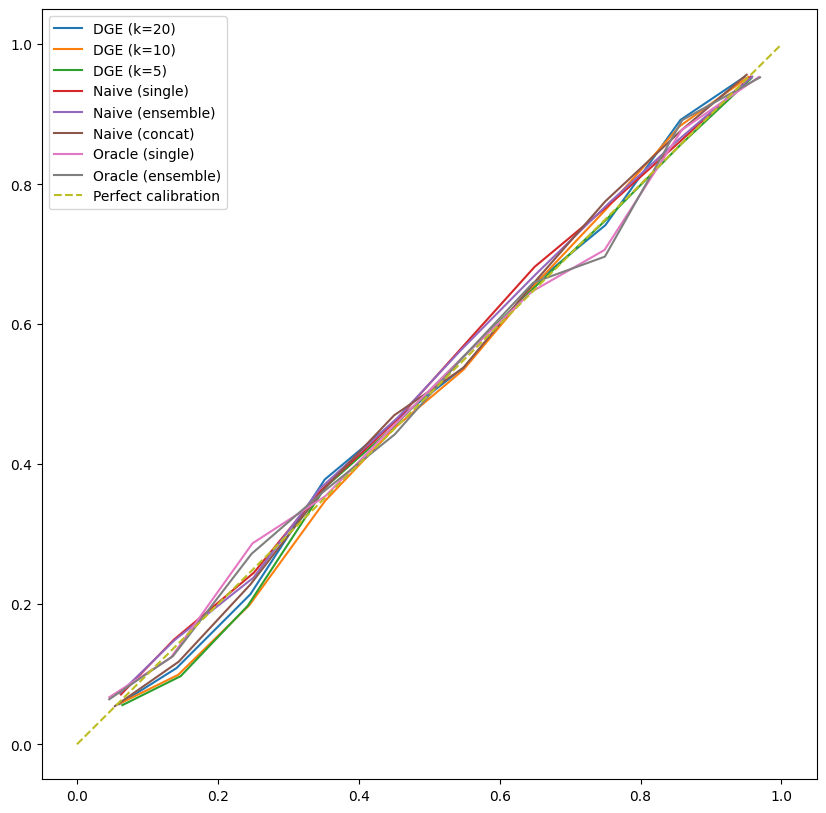

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)        &  0.907 &  0.829 &  0.827 &      0.836 &   0.819 &  0.387 &  0.120 \\
DGE (k=10)        &  0.907 &  0.829 &  0.828 &      0.833 &   0.824 &  0.388 &  0.120 \\
DGE (k=5)         &  0.906 &  0.828 &  0.826 &      0.838 &   0.814 &  0.389 &  0.121 \\
Naive (single)    &  0.906 &  0.830 &  0.828 &      0.841 &   0.815 &  0.391 &  0.120 \\
Naive (ensemble)  &  0.906 &  0.829 &  0.825 &      0.845 &   0.806 &  0.391 &  0.120 \\
Naive (concat)    &  0.910 &  0.830 &  0.828 &      0.836 &   0.821 &  0.380 &  0.118 \\
Oracle (single)   &  0.911 &  0.833 &  0.830 &      0.845 &   0.816 &  0.379 &  0.117 \\
Oracle (ensemble) &  0.911 &  0.834 &  0.831 &      0.844 &   0.819 &  0.378 &  0.117 \\
\bottomrule
\end{tabular}

n_total 442 n_train: 265
n_total 569 n_train: 341
Dataset breast_cancer



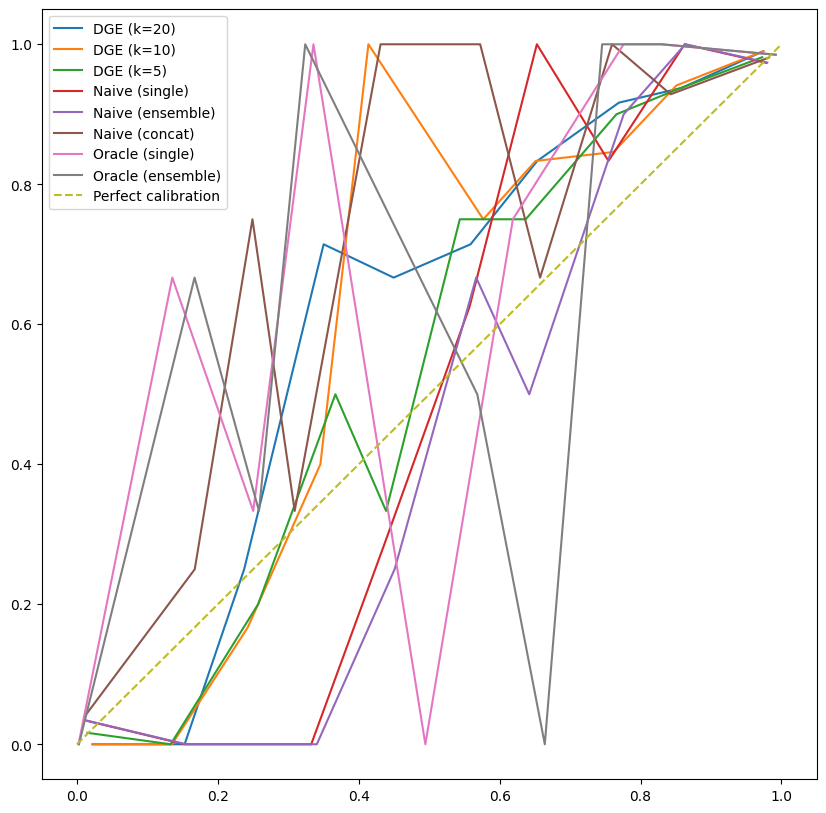

\begin{tabular}{lrrrrrrr}
\toprule
{} &    AUC &    Acc &     F1 &  Precision &  Recall &    NLL &  Brier \\
\midrule
DGE (k=20)        &  0.987 &  0.939 &  0.951 &      0.957 &   0.944 &  0.152 &  0.044 \\
DGE (k=10)        &  0.989 &  0.947 &  0.958 &      0.958 &   0.958 &  0.140 &  0.039 \\
DGE (k=5)         &  0.983 &  0.952 &  0.962 &      0.952 &   0.972 &  0.162 &  0.043 \\
Naive (single)    &  0.975 &  0.947 &  0.959 &      0.946 &   0.972 &  0.207 &  0.049 \\
Naive (ensemble)  &  0.978 &  0.947 &  0.959 &      0.946 &   0.972 &  0.184 &  0.047 \\
Naive (concat)    &  0.978 &  0.930 &  0.943 &      0.964 &   0.923 &  0.193 &  0.054 \\
Oracle (single)   &  0.996 &  0.969 &  0.975 &      0.979 &   0.972 &  0.082 &  0.025 \\
Oracle (ensemble) &  0.996 &  0.965 &  0.972 &      0.972 &   0.972 &  0.081 &  0.025 \\
\bottomrule
\end{tabular}

All scores:
\begin{tabular}{lrrrrrrr}
\toprule
{} &     AUC &     Acc &      F1 &  Precision &  Recall &     NLL &   Brier \\
\midrule
DGE (k=1

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_scores = []
dataset_type = 'classification'

for dataset in datasets:
    
    workspace_folder = os.path.join("workspace", dataset,model_name)
    results_folder = os.path.join("uncertainty_results",dataset,model_name)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose)
    if X_gt.targettype != dataset_type:
        continue
    
    print(f'Dataset {dataset}\n')
    
    y_preds, scores = predictive_experiment(X_gt,
                      X_syns,
                      workspace_folder=workspace_folder,
                      results_folder=results_folder,
                      save=save,
                      load=load)

    print(scores.to_latex())

    all_scores.append(scores)

print('All scores:')
all_scores = pd.concat(all_scores)
df_mean = all_scores.groupby(level=0).mean()
print(df_mean.to_latex())

# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [ ]:
from DGE_experiments import model_evaluation_experiment

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    res = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, model_type='mlp')[0]
    print(res)


Aggregate approaches:
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/

# Model Selection
Essentially repeat the above for different models

In [ ]:
from DGE_experiments import model_selection_experiment

if X_gt.targettype is not None:
    if X_gt.targettype == 'classification':
        metric = 'Acc'
    elif X_gt.targettype == 'regression':
        metric = 'MAE'
    
    results, means_sorted = model_selection_experiment(X_gt, X_syns, relative=False, metric=metric, workspace_folder=workspace_folder, load=load, save=save)


print(results.to_latex())

Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
T

IndexError: index 113985 is out of bounds for axis 0 with size 272

## Influence of synthetic data size

Let's study the effect of synthetic data size.

In [ ]:
from DGE_experiments import predictive_varying_nsyn

predictive_varying_nsyn(X_gt, X_syns, dataset, model_name, n_models,
                        nsyn, results_folder, workspace_folder, load, save, verbose=True)


## Density estimation


In [ ]:
from DGE_experiments import density_experiment

if X_gt.targettype is None:
    density_experiment(X_gt, X_syns, load, save)


# Model parameter estimation
Using a linear model

# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 